# 01-INDUCTOR EXAMPLE<img src="logo.png" style="float:right; max-width: 180px; display: inline" alt="logo" /></a>

# Inductor thermal resistance estimation models with dimensional analysis and power-law model regression
*Originally written by Marc Budinger, INSA Toulouse, France*<br>
*Adapted to illustrate pyVPLM application case*

## 1 - Introduction
<a id="1"></a>

Transportation system is facing changes with greener (lower consumption, better depollution systems) and more electic (hybrid) or even totally electric vehicles.<br>
The [WATT system](http://www.pvi.fr/wattsystem-watt-system,172.html) developped by PVI company is a perfect illustration of electric mobility with electric buses (using batteries and supercapacitor) and a specific infrastructure with stop station equiped with fast chage connector (also using capacitors).<br>

<figure>
    <img src="./01_inductor_example/watt_system.jpg" alt="WATT" style="height:200px">
    <figcaption>Fig.1 - WATT system tested in Nice airport.</figcaption>
</figure>

As soon as variable voltage energy storage is used, DC-DC converter are employed. Those conversers made of: inductor, IGBT, capacitor and cooling system (heatsink equiped with fans) should be designed by electric specialist (on frequency, filtering, transient power and energy loss) but also thermal engineers.<br>

We will illustrate in this notebook how we can construct estimation models to replace costly finite element thermal simulation of the insulator and more precisely produce an estimate of the $R_th$ thermal resistance as a function of geometry and materials.<br>

This is very interesting for various reasons:
- The global system optimised design calculation time will drop drastically,
- Engineers (even from different expertise domains) will have an idea of the influencing parameters (design drivers) and their impact,
- The obtained formulation represent knowledge that can be disseminated and used without any software licence.

<font color=blue>Table of contents:</font><br>
[1 - Introduction](#1-Introduction)<br>
[2 - Thermal FEM presentation](#2)<br>
[3 - Buckingham theorem and dimensional analysis](#3)<br>
[4 - Design of experiments](#4)<br>
[5 - Variable power-law model regression](#5)

## 2 - Thermal FEM presentation [§](#1)
<a id="2"></a>

To estimate inductor thermal resistance, a 2D finite element model on COMSOL (P-type core, other forms could be find [here](https://www.ferroxcube.com)) is developped, with following assumptions:
- the convective heat transfer is negligible compared to the conduction with heatsink (trough lower base)
- the base junction temparature is constant and fixed to 300 Kelvins (no influence on conductive resistance but necessary to calculate hot spot temperature)
- the winding can be represented by an equivalent homogenous thermal conductivity

<figure>
    <img src="./01_inductor_example/FEM.png" alt="FEM" style="height:400px">    
    <figcaption>Fig.2 - Insulator FEM.</figcaption>
</figure>

> **Note**: Following table shows the impact of materials on thermal transfert optimization. Configuration (3) is considered for our simulations.
>
|   Central Axis     | Airgap  | Hot spot Temperature |
| -------------- | --------------| -----------|
| Air | Air       | 122 °C            |
| Air | Resin   | 90 °C |
| Aluminum   | Resin  | 61 °C | 

<br>
<figcaption>Tab.1 - Insulator material optimization (P=36W, airgap=1mm, D=100mm).</figcaption>

## 3 - Buckingham theorem and dimensional analysis [§](#1)
<a id="3"></a>

FEM is defined using a lot of parameters:
- Geometrical: $D_1$, $D_2$,...,$H_i$, $e$
- Material (conductivity): $\lambda_{winding}$, $\lambda_{FERRITE}$
- Thermal/power-loss density conditions: $T_{base} = 300K$, $\delta=P/V_{winding}=cste$

To reduce regression model handled parameters, we will first consider that (exept for airgap), geometry evolution is homotetic:<br>
$\frac{D_1}{D_4,ref}=\frac{D_2}{D_4,ref}=\frac{D_3}{D_4,ref}=\frac{D_1}{D_4,ref}=\frac{H_i}{D_4,ref}=\frac{D_4}{D_4,ref}$

Where ref represent reference component. Therefore, considering $D=D_4$, the thermal resistance can be expressed as follows:<br>
$R_{th}=f(D,e,\lambda_{winding},\lambda_{FERRITE})$<br>

But applying [Buckingham theorem](https://en.wikipedia.org/wiki/Buckingham_%CF%80_theorem) can even reduce this expression handling limited number of dimensionless parameters.

> **Exercice**: Reduce the number of variables to manipulate applying the **buckingham_theorem** from **SizingLab.variablepowerlaw** package. Give expression of $\pi_i$ numbers. You can vary expressions using different repetitive sets (*see first method from **PositiveParameterSet** Class*)<br>

In [3]:
# Import pyVPLM modules/functions
from pyvplm.core.definition import PositiveParameter, PositiveParameterSet
from pyvplm.addon.variablepowerlaw import buckingham_theorem

# Declare physical variables and set
rth = PositiveParameter('rth', [0.01, 100], 'K/W', 'thermal resistance hot spot/base')
d = PositiveParameter('d', [10e-3, 150e-3],'m','pot external diameter')
e = PositiveParameter('e', [.1e-3, 10e-3], 'm', 'airgap thickness')
LAMBDA_FERRITE = PositiveParameter('LAMBDA_FERRITE', [5], 'W/m/K', 'thermal conductivity for ferrite')
lambda_wind = PositiveParameter('lambda_wind', [.1, 3], 'W/(m*K)', 'equivalent thermal conductivity for winding')
parameter_set = PositiveParameterSet(rth, d, e, lambda_wind,  LAMBDA_FERRITE)

# Define d and lambda_wind to be first elected as repetitive set
parameter_set.first('d', 'lambda_wind')
parameter_set.latex_render()

# Calculate pi parameters with first repetitive set found in parameters' order
pi_set, _ = buckingham_theorem(parameter_set, track=False)
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

To obtain different $\pi$ set expressions you can use the **automatic_buckingham** function and elect expression afterwards.

> **Note**: This step is optional, and if previous expressions fit your need just skip to §4 and avoid long calculation time to evaluate all the alternative repetitive sets.

In [4]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import automatic_buckingham

# Import additional libs
import ipywidgets as widgets

# Compute automatic search of pi [step that may take a while, so be patient]
combinatory_pi_set, exp_dict = automatic_buckingham(parameter_set, track=False)
    
# Create and display widget
pi_set_number = widgets.Dropdown(options=exp_dict, description='Choose Pi Set')
display(pi_set_number)

Dropdown(description='Choose Pi Set', options={'pi1=d**1.0*lambda_wind**1.0*rth**1.0  |  pi2=d**-1.0*e**1.0  |…

In [5]:
# Display selected pi set
pi_set = combinatory_pi_set[pi_set_number.value][0]
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 4 - Design of experiments [§](#1)
<a id="4"></a>

As we want an estimate of the $R_{th}$ parameter, we will have to construct a [DOE](https://en.wikipedia.org/wiki/Design_of_experiments) on the different physical parameters that are covering "quite well" the Pi space.<br>
A good coverage is considered with [fullfact](https://en.wikipedia.org/wiki/Factorial_experiment) DOE on logarithmic values of $\pi$: this can be done using **pixdoe.create_const_doe** method.

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>


Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>




Set reduction factor (from feasible to optimal) is 92.59%



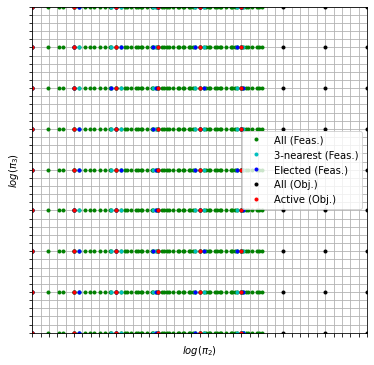

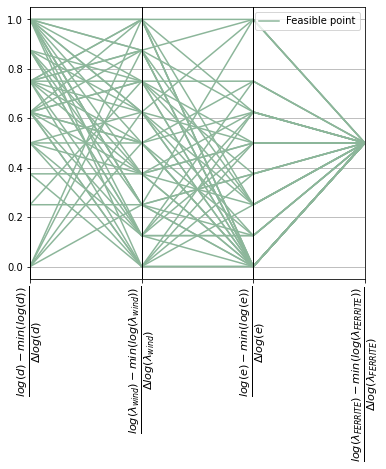


 REMINDER: while importing parameters'values to COMSOL use following units
d:meter
lambda_wind:kilogram * meter / kelvin / second ** 3
e:meter
LAMBDA_FERRITE:kilogram * meter / kelvin / second ** 3

 ./01_inductor_example/input_01.txt file created with success...


D:\Projets Python\PyVPLM\pyvplm-master\pyvplm\core\definition.py:125: UserWarning: accessing private attribute value
  warnings.warn("accessing private attribute value")


In [7]:
# Change matplotlib visualisation parameter
%matplotlib inline

# Import pyVPLM modules/functions
from pyvplm.core.definition import Constraint, ConstraintSet
from pyvplm.addon.pixdoe import create_const_doe
from pyvplm.addon.variablepowerlaw import declare_func_x_to_pi, reduce_parameter_set, declare_constraints
from pyvplm.addon.comsoladdon import save_file

# Import pandas
import pandas

# Extract Pi0 and Rth before calculating DOE
reduced_parameter_set, reduced_pi_set = reduce_parameter_set(parameter_set, pi_set, elected_output='rth')
reduced_pi_set.latex_render()
reduced_parameter_set.latex_render()

# Add dimensional constraints <=> e/d=pi2<=0.1
constraint1 = Constraint('e/d<=0.1')
parameters_constraints = declare_constraints(reduced_parameter_set, ConstraintSet(constraint1))

# Save function to translate x parameters to pi parameters
func_x_to_pi = declare_func_x_to_pi(reduced_parameter_set, reduced_pi_set)

# Generate at least 50 points DOE on physical parameters to have proper fullfact doe on PI (distance criteria is 1/5 and 3 points elected)
doeX, _ = create_const_doe(reduced_parameter_set, reduced_pi_set, func_x_to_pi, whished_size=50, parameters_constraints = parameters_constraints)

# Save .txt file compatible with COMSOL
file_name = './01_inductor_example/input_01'
save_file(doeX, file_name, reduced_parameter_set, is_SI=True)

> *Note:<br>
The calculated DOE is expressed in SI units and not defined units, therefore is_SI parameter for save_csv function must be set to* ***True***

## 5 - Variable power-law model regression [§](#1)
<a id="5"></a>

Multiple Comsol FEM simulations have been performed on DOE generated in [§4](#4).<br>
The COMSOL result file ***./01_inductor_example/output_01.txt*** summarizes usefull data. Let us display it and then perform post-processing to obtain $R_{th}$ as the ratio of temperature drop to power loss.

In [8]:
# Import pyVPLM modules/functions
from pyvplm.addon.comsoladdon import import_file

# Import FEM thermal simulations results and plot 3 first points
doeX_FEM = import_file('./01_inductor_example/output_01', parameter_set, units='from_file')
doeX_FEM.head(n=3)

D:\Projets Python\PyVPLM\pyvplm-master\pyvplm\addon\comsoladdon.py:272: UserWarning: parameter rth not found in imported file!
  warnings.warn("parameter {} not found in imported file!".format(parameter))


,d,lambda_wind,e,LAMBDA_FERRITE,Total_heat_source [W],Temperature [K]
0,0.150000,3.0,0.0001,5.0,120.939807,381.640354
1,0.087272,3.0,0.0001,5.0,23.835969,327.775352
2,0.050776,3.0,0.0001,5.0,4.700290,309.477255


In [9]:
# Make little post-processing by replacing power loss and temperature drop by Rth:
doeX_FEM['rth'] = (doeX_FEM['Temperature [K]']-300)/doeX_FEM['Total_heat_source [W]']
doeX_FEM = doeX_FEM.drop(columns=['Total_heat_source [W]','Temperature [K]'])
doeX_FEM = doeX_FEM[list(parameter_set.dictionary.keys())]
doeX_FEM.head(n=5)

,d,lambda_wind,rth,e,LAMBDA_FERRITE
0,0.150000,3.0,0.675049,0.000100,5.0
1,0.087272,3.0,1.165270,0.000100,5.0
2,0.050776,3.0,2.016313,0.000100,5.0
3,0.087272,3.0,1.180826,0.000251,5.0
4,0.050776,3.0,2.055372,0.000251,5.0


We want to perform a linear regression to determine $a$ coefficients of the estimation model:<br>
$\pi_{0}=\pi_{1}=f(\pi_{2},\pi_{3})=10^{a_{1}}*\pi_{2}^{a_{2}+a_{22}*log(\pi_{2})+a_{23}*log(\pi_{3})}*\pi_{3}^{a_{3}+a_{33}*log(\pi_{3})}$

Which can be written in log as:<br>
$log(\pi_{1})=a_{1}+a_{2}*log(\pi_{2})+a_{22}*log(\pi_{2})^2+a_{23}*log(\pi_{2})*log(\pi_{3})+a_{3}*log(\pi_{3})+a_{33}*log(\pi_{3})^2$

> **Exercice**: Use **variablepowerlaw.regression_models** method to fit results.


Based on following criteria definitions:
1 - C = max(abs(error))
2 - C = mean(abs(error))
3 - C = mean(error)
4 - C = sqrt(1/(n-1)*sum((error-mean(error))²))
Enter selected criteria (1/[2]/3/4)?)2


D:\Projets Python\PyVPLM\pyvplm-master\pyvplm\addon\variablepowerlaw.py:1352: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].xaxis.set_major_formatter(ticker.FixedFormatter(majors))


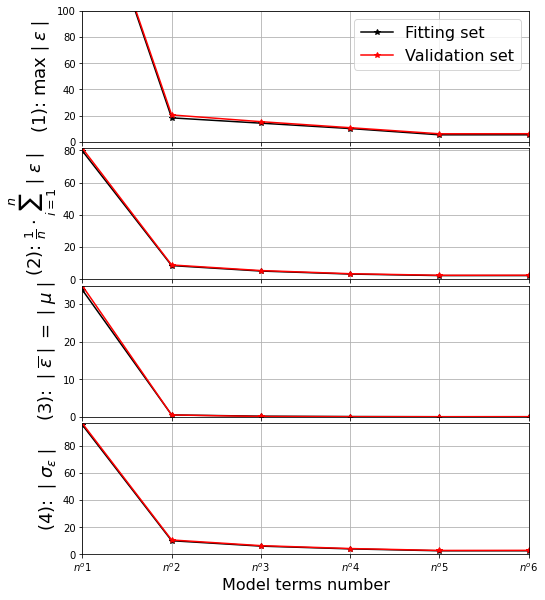

In [10]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import declare_func_x_to_pi, regression_models

# Define transformation function with full set that time
func_x_to_pi = declare_func_x_to_pi(parameter_set, pi_set)

# Fit with 2nd order model the obtained Pi DOE
doePI = func_x_to_pi(doeX_FEM.values)
models = regression_models(doePI, elected_pi0='pi1', order=2)


Elected model for regression is n°5:


<IPython.core.display.Latex object>

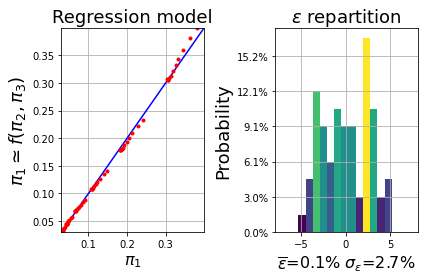

In [11]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import perform_regression

# Plot advanced result for model n°5
perform_regression(doePI, models, choosen_model=5, latex=False)

> **Conclusion**: The model fidelity is quite good and this obtained simple expression can be used to calculate formal derivative for optimization problem.

## Annex : thermal conductivity 

|   Material    | Thermal conductivity |
| -------------- | --------------|
| Copper | 400 W/(mK)            |
| Aluminum  | 200 W/(mK) |
| Air   | 0.03 W/(mK) | 
| Ferrite   | 5 W/(mK) | 
| Resin   | 0.25 W/(mK) |
| Copper+Resin(*)   | 0.5 W/(mK) | 

(*) for a mix of 33% copper, 66% resin

## Note

To obtain help on SizingLab packages, acces the interactive help web page running following code:

In [12]:
import webbrowser, os
new = 2
url = 'file://' + os.path.realpath(os.path.abspath('../../../build/index.html'))
url = url.replace('\\','/')
webbrowser.open(url,new=new)

True